<h1 align = "center">Prediction of a student's mark.</h1>

## 1. Data Preparation

First, we will import the dataset and prepare it for the *Machine Learning* task ahead.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
stud = pd.read_csv('../source-files/student-math.csv', sep = ';')
stud.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


### Creating feature variable <mark>X</mark> and response variable <mark>y</mark>
First we have to create the response variable *final_grade* and separate the column *G3* from the feature variables.

In [4]:
stud['final_grade'] = np.sum(stud[['G1', 'G2', 'G3']], axis = 1)

Dataset <mark>X</mark> contains all the feature variables except *G3* and <mark>y</mark> which contains the *final_grade* column of the **stud** dataframe.

In [5]:
X_non_encoded = stud[stud.columns[: - 2]]
y = np.array(stud['final_grade'])

### Encoding all text values in the feature variable <mark>X</mark>
- Since all the *nominal columns* do not represent any sense of ordering, we can use `sklearn.preprocessing.OneHotEncoder()` library to encode the *nominal columns* into the *One Hot Format* where one categorical variable is represented by 1 and other by 0.


- We will also make a **Pipeline** with the help of `sklearn.compose.ColumnTransformer` class which will apply the desired transformation method on selected columns only.

The list of all the column names which are to be encoded.

In [6]:
nominal_col = [col for col in stud.columns if stud[col].dtype == 'O']

In [7]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [8]:
pipeline = ColumnTransformer([
    ('one_hot_enc', OneHotEncoder(), nominal_col)
], remainder = 'passthrough')

<div class = "alert alert-info">
    The above <strong>Pipeline</strong> transforms all the given list of text columns and pasess all the other features unchanged.
</div>

In [9]:
X = pipeline.fit_transform(X_non_encoded)

### Creating Train and Test sets of <mark>X</mark> and <mark>y</mark>.

We have to import `sklearn.model_selection.train_test_split()` function to create randomly shuffled tain and test sets.

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
stud['school'].value_counts()

GP    349
MS     46
Name: school, dtype: int64

<div class = "alert alert-warning">
    Here, we can see that the dataset is biased towards the <strong>GP</strong> school. Therefore, we should stratify the <em>train</em> and <em>test</em> set so as to preserve distribution in both <em>train</em> and <em>test</em> sets.
</div>

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = stud['school'])

## 2. Modelling and Evaluation

To create a **linear regression** model we have to import `sklearn.linear_model.LinearRegression` class.

In [13]:
from sklearn.linear_model import LinearRegression

In [14]:
lin_reg = LinearRegression()

Now we have to fit *X_train* and *y_train* values to the **Linear Regression**.

In [15]:
model = lin_reg.fit(X_train, y_train)

In [16]:
print('The R-score of the model with test data is {:.4f}'.format(model.score(X_test, y_test)))

The R-score of the model with test data is 0.9658


R-score of `0.9765` means that *97%* of variability in the data can be explained by the model.

- Now we can plot the true *y_test* with the prediction of the *X_test* values by the model.

In [17]:
y_pred = model.predict(X_test)

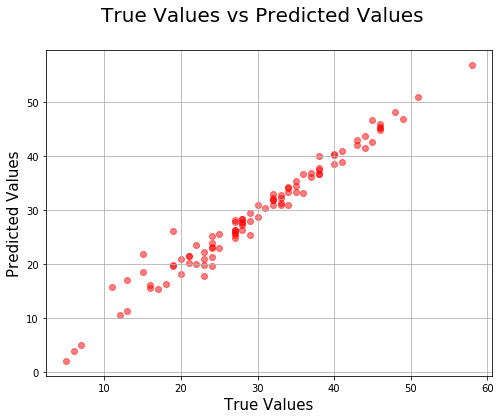

In [18]:
fig, ax = plt.subplots(figsize = (8, 6))
ax.scatter(y_test, y_pred, alpha = 0.5, color = 'red')
ax.set_xlabel('True Values', fontsize = '15')
ax.set_ylabel('Predicted Values', fontsize = '15')
ax.grid()
fig.suptitle('True Values vs Predicted Values', fontsize = 20)
fig.savefig('C:/Users/adity/Downloads/regression_line.png', dpi = 300, bbox_inches = 'tight')
plt.show()

As we can see, there is **linear trend** between most of the *predicted values* and *true values*. This indicates the model is good fit.

## Feature Selection

- Now we will discard all the features which do not affect the model's accuracy at all through *backward elimination*.

In [19]:
import statsmodels.api as sm
from patsy import dmatrices

In [20]:
def backward_elimination(dataset, formula, alpha = 0.05):
    y, X = dmatrices(formula, data = dataset, return_type = 'dataframe')
    features = X.columns
    while(len(features) > 0):
        X_c = sm.add_constant(X[features])
        p_vals = sm.OLS(y, X_c).fit().pvalues[1:]
        if np.amax(p_vals) >= alpha:
            remove_feature = np.argmax(p_vals)
            features = np.delete(features, remove_feature)
        else:
            break
    result = sm.OLS(y, sm.add_constant(X[features])).fit()
    return (features, result)

The formula to obtain *one-hot* encoded dataframe for X and y.

In [21]:
formula = 'final_grade ~ ' + ' + '.join(stud.columns[: -2])

In [22]:
features, fit = backward_elimination(stud, formula)

>The following features are the most imortant features.

In [23]:
features

Index(['age', 'famrel', 'absences', 'G1', 'G2'], dtype='object')

In [24]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            final_grade   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     2662.
Date:                Sun, 31 May 2020   Prob (F-statistic):          2.85e-298
Time:                        19:51:31   Log-Likelihood:                -806.98
No. Observations:                 395   AIC:                             1626.
Df Residuals:                     389   BIC:                             1650.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0777      1.376     -0.056      0.955      -2.784       2.628
age           -0.2017      0.077     -2.626      0.009      -0.353      -0.051
famrel         0.3572      0.106      3.363      0.001       0.148       0.566
absences       0.0437      0.012      3.623      0.000       0.020       0.067
G1             1.1579      0.055     21.041      0.000       1.050       1.266
G2             1.9780      0.049     40.411      0.000       1.882       2.074
==============================================================================
Omnibus:                      216.345   Durbin-Watson:                   1.865
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1268.775
Skew:                          -2.363   Prob(JB):                    3.08e-276
Kurtosis:                      10.400   Cond. No.                         350.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<dl>
    <dt>Statistical inference:
        <dd> The <em>F-test</em> probability is quite low (2.85e-298). Therefore, overall model is significant.</dd>
        <dd> The probability of <em>t-test</em> of all the independent variables is close to zero which implies that all the independent variables are statistically significant.
    </dt> 
</dl>

### Error Analysis

- The errors must satisfy certain requirements for the statistical test of the model to be error free.
    - The errors must be random.
    - The distribution of errors must have constant variance.
    - The error distribution should be similar to *normal distribution*

- Plot standardized errors against the predicted values of the model.

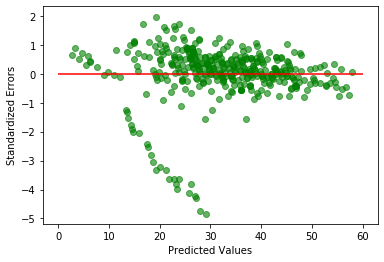

In [25]:
resid_std = fit.resid_pearson
y_pred = fit.fittedvalues
plt.scatter(y_pred, resid_std, color = 'green', alpha = 0.6)
plt.hlines(0, 0, 60, color = 'red')
plt.xlabel('Predicted Values')
plt.ylabel('Standardized Errors')
plt.savefig('C:/Users/adity/Downloads/erorr_plot.png', dpi = 300, bbox_inches = 'tight')
plt.title('Residual plot - Standardized Errors vs Predicted Values', fontsize = 20)
plt.show()

<dl>
    <dt>Inferences:
        <dd>The errors are randomly distributed.</dd>
        <dd>Variance of of error distribution is almost constant.</dd>
        <dd>There are some outliers below -2.</dd>
        <dd>95% of errors lie between -2 to 2 which is indicative of normal distribution.</dd>
    </dt>
</dl>

- Now we can plot a QQ Plot(quantile plot) which plots the quantiles of an empirical distribution with theoritical quantiles.
- We can use QQ Plot to compare the *error distribution* with a theoritical <font color = "blue">normal distribution</font>.
- A perfectly normal distribution would overlap on the <font color = "red">red line</font>.

In [26]:
from scipy import stats

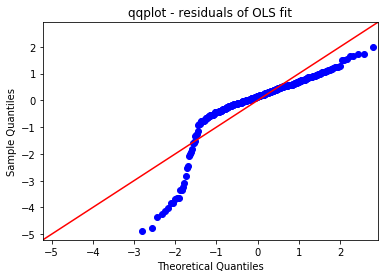

In [27]:
res = fit.resid_pearson
probplot = sm.ProbPlot(res, stats.norm, fit = True)
fig = probplot.qqplot(line = '45')
plt.title('qqplot - Residuals of OLS fit compared with normal distribution.', fontsize = 20)
plt.savefig('C:/Users/adity/Downloads/qqplot_error_norm.png', dpi = 300, bbox_inches = 'tight')
plt.show()

<dl>
    <dt>Inferences:
        <dd>The distribution of errors appears to be skewed.</dd>
        <dd>Most of the errors are concentrated around the straight line.</dd>
        <dd>The error distribution seem to have heavy-tails implying positive kurtois.</dd>
        <dd>Overally, the error distribution conforms to normal distribution.</dd>
    </dt>
</dl>

<div class = "alert alert-success">
The overall error analysis suggests that the model obtained is <strong>significant</strong> and the statistical tests have very low chance of error.
</div>

*************

## Regression Inferences

In [28]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            final_grade   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     2662.
Date:                Sun, 31 May 2020   Prob (F-statistic):          2.85e-298
Time:                        19:51:32   Log-Likelihood:                -806.98
No. Observations:                 395   AIC:                             1626.
Df Residuals:                     389   BIC:                             1650.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0777      1.376     -0.056      0.955      -2.784       2.628
age           -0.2017      0.077     -2.626      0.009      -0.353      -0.051
famrel         0.3572      0.106      3.363      0.001       0.148       0.566
absences       0.0437      0.012      3.623      0.000       0.020       0.067
G1             1.1579      0.055     21.041      0.000       1.050       1.266
G2             1.9780      0.049     40.411      0.000       1.882       2.074
==============================================================================
Omnibus:                      216.345   Durbin-Watson:                   1.865
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1268.775
Skew:                          -2.363   Prob(JB):                    3.08e-276
Kurtosis:                      10.400   Cond. No.                         350.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [29]:
import seaborn as sns

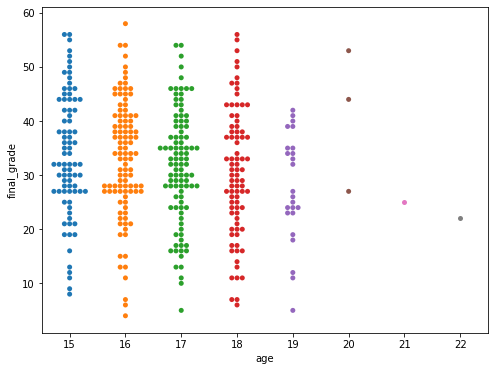

In [78]:
plt.figure(figsize = (8, 6))
sns.swarmplot(stud['age'], stud['final_grade'])
plt.title('Final Grade according to Age')
plt.savefig('C:/Users/adity/Downloads/age_plot.png', dpi = 300, bbox_inches = 'tight')
plt.show()

>From the above plot we can show that variability in *final_grade* is not significant upto age 18.<br>
>Students with age over 18, tend to obtain low grades.

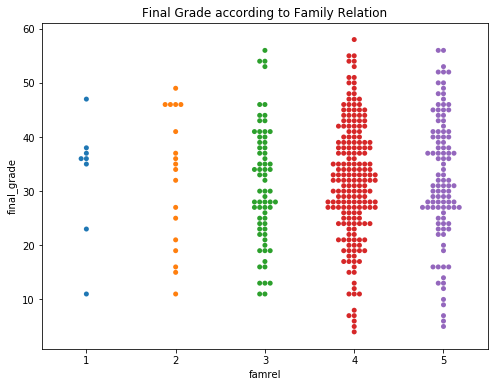

In [82]:
plt.figure(figsize = (8, 6))
sns.swarmplot(stud['famrel'], stud['final_grade'])
plt.title('Final Grade according to Family Relation')
plt.savefig('C:/Users/adity/Downloads/famrel_plot.png', dpi = 300, bbox_inches = 'tight')
plt.show()

>From the above plot we can conclude that many studnets have good relation with their families.<br>
>Students with a *famrel* of 3 or more tend to perform better than other students.

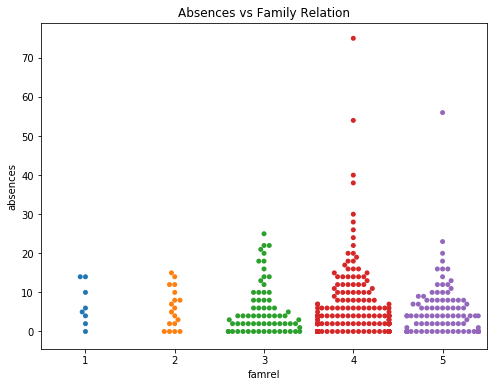

In [83]:
plt.figure(figsize = (8, 6))
sns.swarmplot(stud['famrel'], stud['absences'])
plt.title('Absences vs Family Relation')
plt.savefig('C:/Users/adity/Downloads/absences_famrel.png', dpi = 300, bbox_inches = 'tight')
plt.show()

>The above plot shows the data of *absences vs family relation*.<br>
>We can observe that students having good family relation particulary a *famrel* of 4, tend to have higher amount absences. This could be due to spending time with family more.

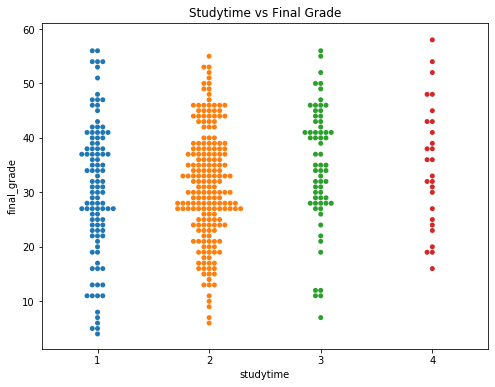

In [86]:
plt.figure(figsize = (8, 6))
sns.swarmplot(stud['studytime'], stud['final_grade'])
plt.title('Studytime vs Final Grade')
plt.savefig('C:/Users/adity/Downloads/studytime.png', dpi = 300, bbox_inches = 'tight')
plt.show()